In [ ]:
# installation 
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install music21
!pip install pypianoroll
!pip install -q git+https://github.com/tensorflow/docs
!pip install llvmlite --ignore installed 
!pip install tensorflow-addons
!pip install --upgrade --ignore-installed tensorflow
!pip -q imageio
!pip install librosa 
!pip install tensorflow
!pip install numba==0.53 --user

In [82]:
#imports
import os 
import glob 
import pickle 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import music21 as m21

from tqdm import tqdm
from music21 import converter, instrument, note, chord, stream
from keras.utils import np_utils
import json
import IPython.display
from datetime import datetime
import random

import torch
import torch.nn as nn
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tqdm.notebook import tqdm, trange

import random
import itertools 
import librosa
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers 

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [83]:
# Setting up the seed for reproducibility
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [84]:
# Training variables
train_size = 60000
BATCH_SIZE = 10
test_size = 10000
# was epochs = 20
epochs = 20
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 10

BASE_PATH = '../swifty-music/metadata/genres_original_ts'

## Network Architecture ##

In [85]:
class Resnet1DBlock(tf.keras.Model):
    """
    Resnet1DBlock is a custom keras layer that implements a 1D Resnet block for use in the encoder and decoder of the WaveNet model.    
    """
    def __init__(self, kernel_size, filters,type='encode'):
        # super(Resnet1DBlock, self).init()
        super().__init__()
        # sets up the conditions for the block to be either an encoder or decoder 
    
        if type=='encode':
            self.conv1a = layers.Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = layers.Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = layers.Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = tf.keras.layers.BatchNormalization()
            self.norm1b = tf.keras.layers.BatchNormalization()
        else:
            return None

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv1a(x)
        x = self.norm1a(x)
        x = layers.LeakyReLU(0.4)(x)

        x = self.conv1b(x)
        x = self.norm1b(x)
        x = layers.LeakyReLU(0.4)(x)

        x += input_tensor
        return tf.nn.relu(x)

In [86]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(1,90001)),
                ## 1D Convolutional Layers: strides, dilation_rate, groups 
                layers.Conv1D(64,1,2),
                Resnet1DBlock(64,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(128,1,2),
                Resnet1DBlock(128,1),
                layers.Conv1D(256,1,2),
                Resnet1DBlock(256,1),
                # No activation
                layers.Flatten(),
                layers.Dense(latent_dim+latent_dim)

            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                layers.Reshape(target_shape=(1,latent_dim)),
                Resnet1DBlock(512,1,'decode'),
                layers.Conv1DTranspose(512,1,1),
                Resnet1DBlock(256,1,'decode'),
                layers.Conv1DTranspose(256,1,1),
                Resnet1DBlock(128,1,'decode'),
                layers.Conv1DTranspose(128,1,1),
                Resnet1DBlock(64,1,'decode'),
                layers.Conv1DTranspose(64,1,1),
                # No activation
                layers.Conv1DTranspose(90001,1,1),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [87]:
# optimizer = tf.keras.optimizers.Adam(
#     learning_rate=0.001,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     amsgrad=False,
#     weight_decay=None,
#     clipnorm=None,
#     clipvalue=None,
#     global_clipnorm=None,
#     use_ema=False,
#     ema_momentum=0.99,
#     ema_overwrite_frequency=None,
#     jit_compile=True,
# ) 

In [88]:
# optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)

In [89]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)
# was 0.0003, the 0.0003 was too high, the loss was not decreasing, yields a inaccurate model 
# with respect to the type of music (piano)

In [90]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    """
    Returns the log-normal pdf of a sample given a mean and log-variance.
    """
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

In [91]:
@tf.function
def compute_loss(model, x):
    """
    Computes the loss of the model using the given input x such that 
    """
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

## Loss Optimization ## 
Using K loss: The KL divergence tells us how well the probability distribution Q approximates the probability distribution P by calculating the cross-entropy minus the entropy. Intuitively, you can think of that as the statistical measure of how one distribution differs from another. In VAE, let X be the data we want to model, z be latent variable, P(X) be the probability distribution of data, P(z) be the probability distribution of the latent variable and P(X|z) be the distribution of generating data given latent variable.

In the case of variational autoencoders, our objective is to infer P(z) from P(z|X). P(z|X) is the probability distribution that projects our data into latent space. But since we do not have the distribution P(z|X), we estimate it using its simpler estimation Q.

Now while training our VAE, the encoder should try to learn the simpler distribution Q(z|X) such that it is as close as possible to the actual distribution P(z|X). This is where we use KL divergence as a measure of a difference between two probability distributions. The VAE objective function thus includes this KL divergence term that needs to be minimized.

DKL[Q(z|X)||P(z|X)] = E[ logQ(z|X) − logP(z|X) ]

## VAE Objective: In a Variational Autoencoder (VAE), the main goal is to learn a latent representation (probability distribution) of the data that can be used for tasks such as generation, compression, or denoising. The latent variable is denoted as 'z'. ##

1. Probability Distributions:
    - P(X): Probability distribution of the data.
    - P(z): Probability distribution of the latent variable.
    - P(X|z): Distribution of generating data given a latent variable.

2. Inference Problem: The ultimate goal of a VAE is to infer the true posterior distribution of the latent variable given the data, denoted as P(z|X). However, this distribution is often complex and difficult to compute directly.

3. Variational Inference: VAEs use a simpler distribution Q(z|X) (inferred by the encoder) to approximate the true posterior P(z|X). This is a form of variational inference.

4. KL Divergence Term: The difference between Q(z|X) and P(z|X) is measured using the KL divergence, which quantifies how one distribution differs from another. The KL divergence between Q(z|X) and P(z|X) is denoted as DKL[Q(z|X)||P(z|X)].

5. Objective Function: The VAE's objective function consists of two components:
    - Reconstruction Loss: Measures how well the generated data from the latent variable matches the actual data (often measured by a cross-entropy term).
    - Regularization Term (KL Divergence): Measures the difference between the inferred distribution Q(z|X) and the true posterior P(z|X).

### The overall objective of training a VAE is to minimize this combined loss, which encourages the encoder to learn a Q(z|X) distribution that is both accurate in reconstructing the data and is close to the true P(z|X) distribution. ###


In [80]:
# @tf.function
# def train_step(model, x, optimizer):
    
#     """Executes one training step and returns the loss.

#        This function computes the loss and gradients, and uses the latter to
#        update the model's parameters.
#      """
#     with tf.GradientTape() as tape:
#             mean, logvar = model.encode(x)
#             z = model.reparameterize(mean, logvar)
#             x_logit = model.decode(z)
#             cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
#             logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
#             logpz = log_normal_pdf(z, 0., 0.)
#             logqz_x = log_normal_pdf(z, mean, logvar)
#             loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
#             reconstruction_loss = tf.reduce_mean(
#                      tf.keras.losses.binary_crossentropy(x, x_logit)
#                  )
#             total_loss = reconstruction_loss+ loss_KL
#     gradients = tape.gradient(total_loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [92]:
def train_step(model, input_data, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the gradients to
    update the model's parameters.

    Args:
        model (tf.keras.Model): The Variational Autoencoder model.
        input_data (tf.Tensor): Batch of input data.
        optimizer (tf.optimizers.Optimizer): The optimizer to update model weights.

    Returns:
        loss (tf.Tensor): The total loss for this training step.
    """

    with tf.GradientTape() as tape:
        # Encode the input data to obtain the mean and log variance of latent distribution
        latent_mean, latent_logvar = model.encode(input_data)
        
        # Reparameterization trick to sample latent variables
        latent_z = model.reparameterize(latent_mean, latent_logvar)
        
        # Decode the latent variables to generate reconstructed data logits
        reconstructed_logits = model.decode(latent_z)
        
        # Compute binary cross-entropy loss for data reconstruction
        binary_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=reconstructed_logits, labels= input_data)
        reconstruction_loss = tf.reduce_mean(
                      tf.keras.losses.binary_crossentropy(input_data, reconstructed_logits)
                  )
        # Compute KL divergence loss between latent distribution and unit Gaussian

         # Calculate log likelihood of latent variables under prior distribution
        logpx_z = -tf.reduce_sum(binary_cross_entropy, axis=[1,2])

        # Calculate log likelihood of latent variables under posterior distribution

        logpz = log_normal_pdf(latent_z, 0., 0.)
        logqz_x = log_normal_pdf(latent_z, latent_mean, latent_logvar)
        loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
        
        # Compute total loss by adding reconstruction loss and KL divergence
        total_loss = reconstruction_loss + loss_KL

    # Calculate gradients and update model parameters
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [93]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

## Loading and Setting up the Data Set ##


In [94]:
def load_and_adjust_audio(audio_path, desired_sequence_length):
    """
    Load an audio file and adjust its length to match the desired sequence length.

    Parameters:
        audio_path (str): Path to the audio file.
        desired_sequence_length (int): Desired sequence length for padding or truncation.

    Returns:
        adjusted_audio (np.ndarray): Audio data with adjusted length.
    """
    sample_ts_, sampling_rate = librosa.load(audio_path, sr=3000, duration=30)

    if sample_ts_.shape[0] > desired_sequence_length:
        # Truncate the audio if it's longer than the desired sequence length
        adjusted_audio = sample_ts_[:desired_sequence_length]
    else:
        # Pad the audio if it's shorter than the desired sequence length
        pad_width = desired_sequence_length - sample_ts_.shape[0]
        # rather than padding it with zeros, we pad it with the the content of the audio itself 
        adjusted_audio  = np.pad(sample_ts_, (0, pad_width), mode='wrap') 
        # adjusted_audio = np.pad(sample_ts_, (0, pad_width), mode='constant', constant_values=0)

    return adjusted_audio

In [95]:
def DataSetLoaderTS(class_):
    '''generate the two training set for Taylor Swift Melody training'''
    music_list = np.array(os.listdir(BASE_PATH+'/'+class_)) 
    # list 1 has the AllTheGirlsYouLovedBefore_# 
    ts_music_1 = []
    ts_music_2 = []
    for name in music_list: 
        # if the name contains 'AllTheGirlsYouLovedBefore' 

        if 'AllTheGirlsYouLovedBefore' in name or "AllTooWell" in name or "AntiHero" in name:
            ts_music_1.append(name) 
        elif 'August' in name or 'BackToDecember' in name:
            ts_music_2.append(name)


    TrackSet_1 = [(BASE_PATH)+'/'+'TS_cropped'+'/%s'%(x) for x in ts_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+'TS_cropped'+'/%s'%(x) for x in ts_music_2]

    print('The number of training tracks is: ', len(TrackSet_1)) 
    print('The number of testing tracks is: ', len(TrackSet_2))
    return TrackSet_1, TrackSet_2 

def load_ts(file_): 
    ''' load the data set from the TS_file'''
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30) 
    # call the load_and_adjust_audio function to adjust the length of the audio 
    data_ = load_and_adjust_audio(file_, 90001)
    data_ = data_.reshape(1,90001)
    return data_
map_data_ts = lambda filename: tf.compat.v1.py_func(load_ts, [filename], [tf.float32]) 


In [72]:
# def DataSetLoaderTS(class_):
#     '''generate the two training set for Taylor Swift Melody training'''
#     music_list = np.array(os.listdir(BASE_PATH+'/'+class_)) 
#     # randomly choose 80% of the music from the TS_cropped folder for training 
#     ts_music_1 = np.random.choice(music_list, size=int(len(music_list)*0.8), replace=False)
#     # the rest 20% of the music from the TS_cropped folder for testing
#     ts_music_2 = np.setdiff1d(music_list, ts_music_1)
#     TrackSet_1 = [(BASE_PATH)+'/'+'TS_cropped'+'/%s'%(x) for x in ts_music_1]
#     TrackSet_2 = [(BASE_PATH)+'/'+'TS_cropped'+'/%s'%(x) for x in ts_music_2]

#     print('The number of training tracks is: ', len(TrackSet_1)) 
#     print('The number of testing tracks is: ', len(TrackSet_2))
#     return TrackSet_1, TrackSet_2 

# def load_ts(file_): 
#     ''' load the data set from the TS_file'''
#     data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30) 
#     # call the load_and_adjust_audio function to adjust the length of the audio 
#     data_ = load_and_adjust_audio(file_, 90001)
#     data_ = data_.reshape(1,90001)
#     return data_
# map_data_ts = lambda filename: tf.compat.v1.py_func(load_ts, [filename], [tf.float32]) 

In [96]:
TrackSet_1_TS, TrackSet_2_TS = DataSetLoaderTS('TS_cropped')

The number of training tracks is:  26
The number of testing tracks is:  18


In [97]:
sample_ts = TrackSet_1_TS[1] 
sample_ts_, sampling_rate = librosa.load(sample_ts,sr=3000, offset=0.0, duration=30) 
ipd.Audio(sample_ts_,rate=3000)

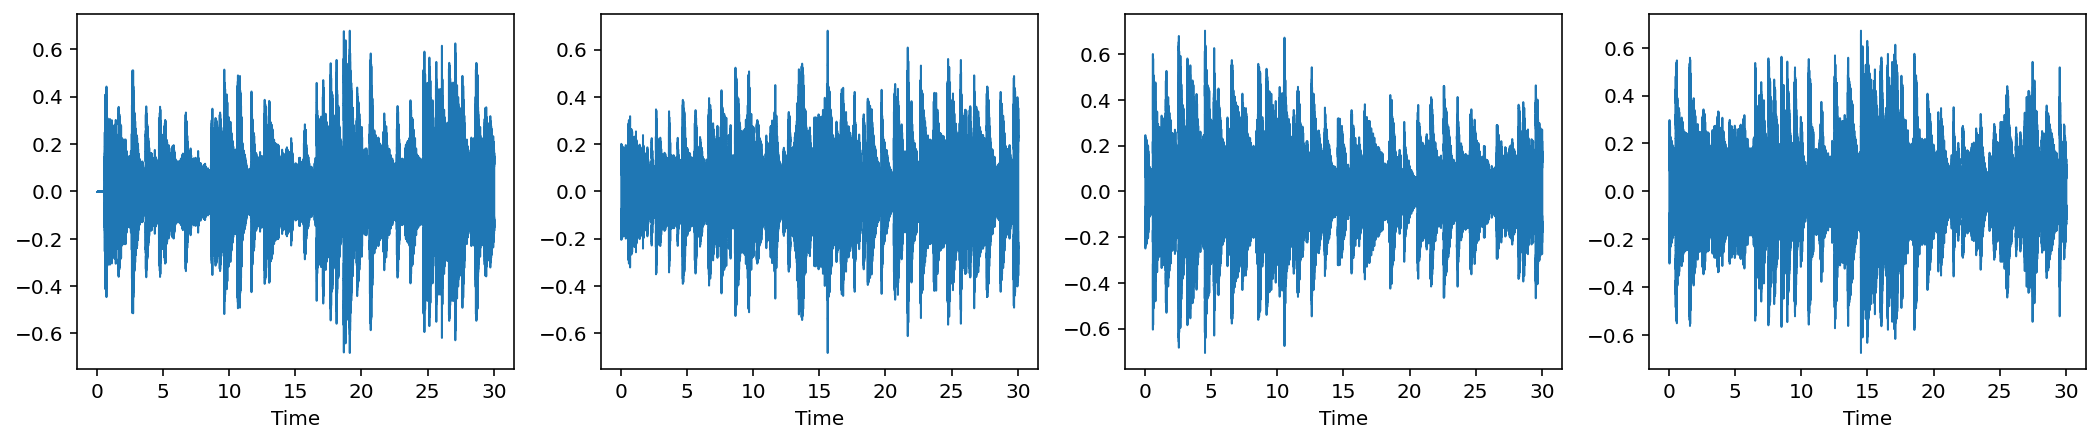

In [98]:
# waveplot is NOW waveshow
import librosa.display
plt.figure(figsize=(18,15))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    j = load_ts(TrackSet_1_TS[i])
    librosa.display.waveshow(j[0], sr=3000)

In [99]:

train_dataset_ts = ( 
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1_TS))
    .map(map_data_ts, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset_ts = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2_TS))
    .map(map_data_ts, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)


In [77]:
# Displaying the training data
import librosa.display

def generate_and_save_images(model, epoch, test_sample, save):
    """
    Generates and saves a plot of the original and reconstructed waveforms.
    """
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        librosa.display.waveshow(wave[0], sr=3000)

        
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.show()

In [100]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset_ts.take(1):
    test_sample = test_batch[0]

Epoch Number: 20, Test set ELBO: -4465.1767578125, The time elapse for current epoch: 2.6412928104400635


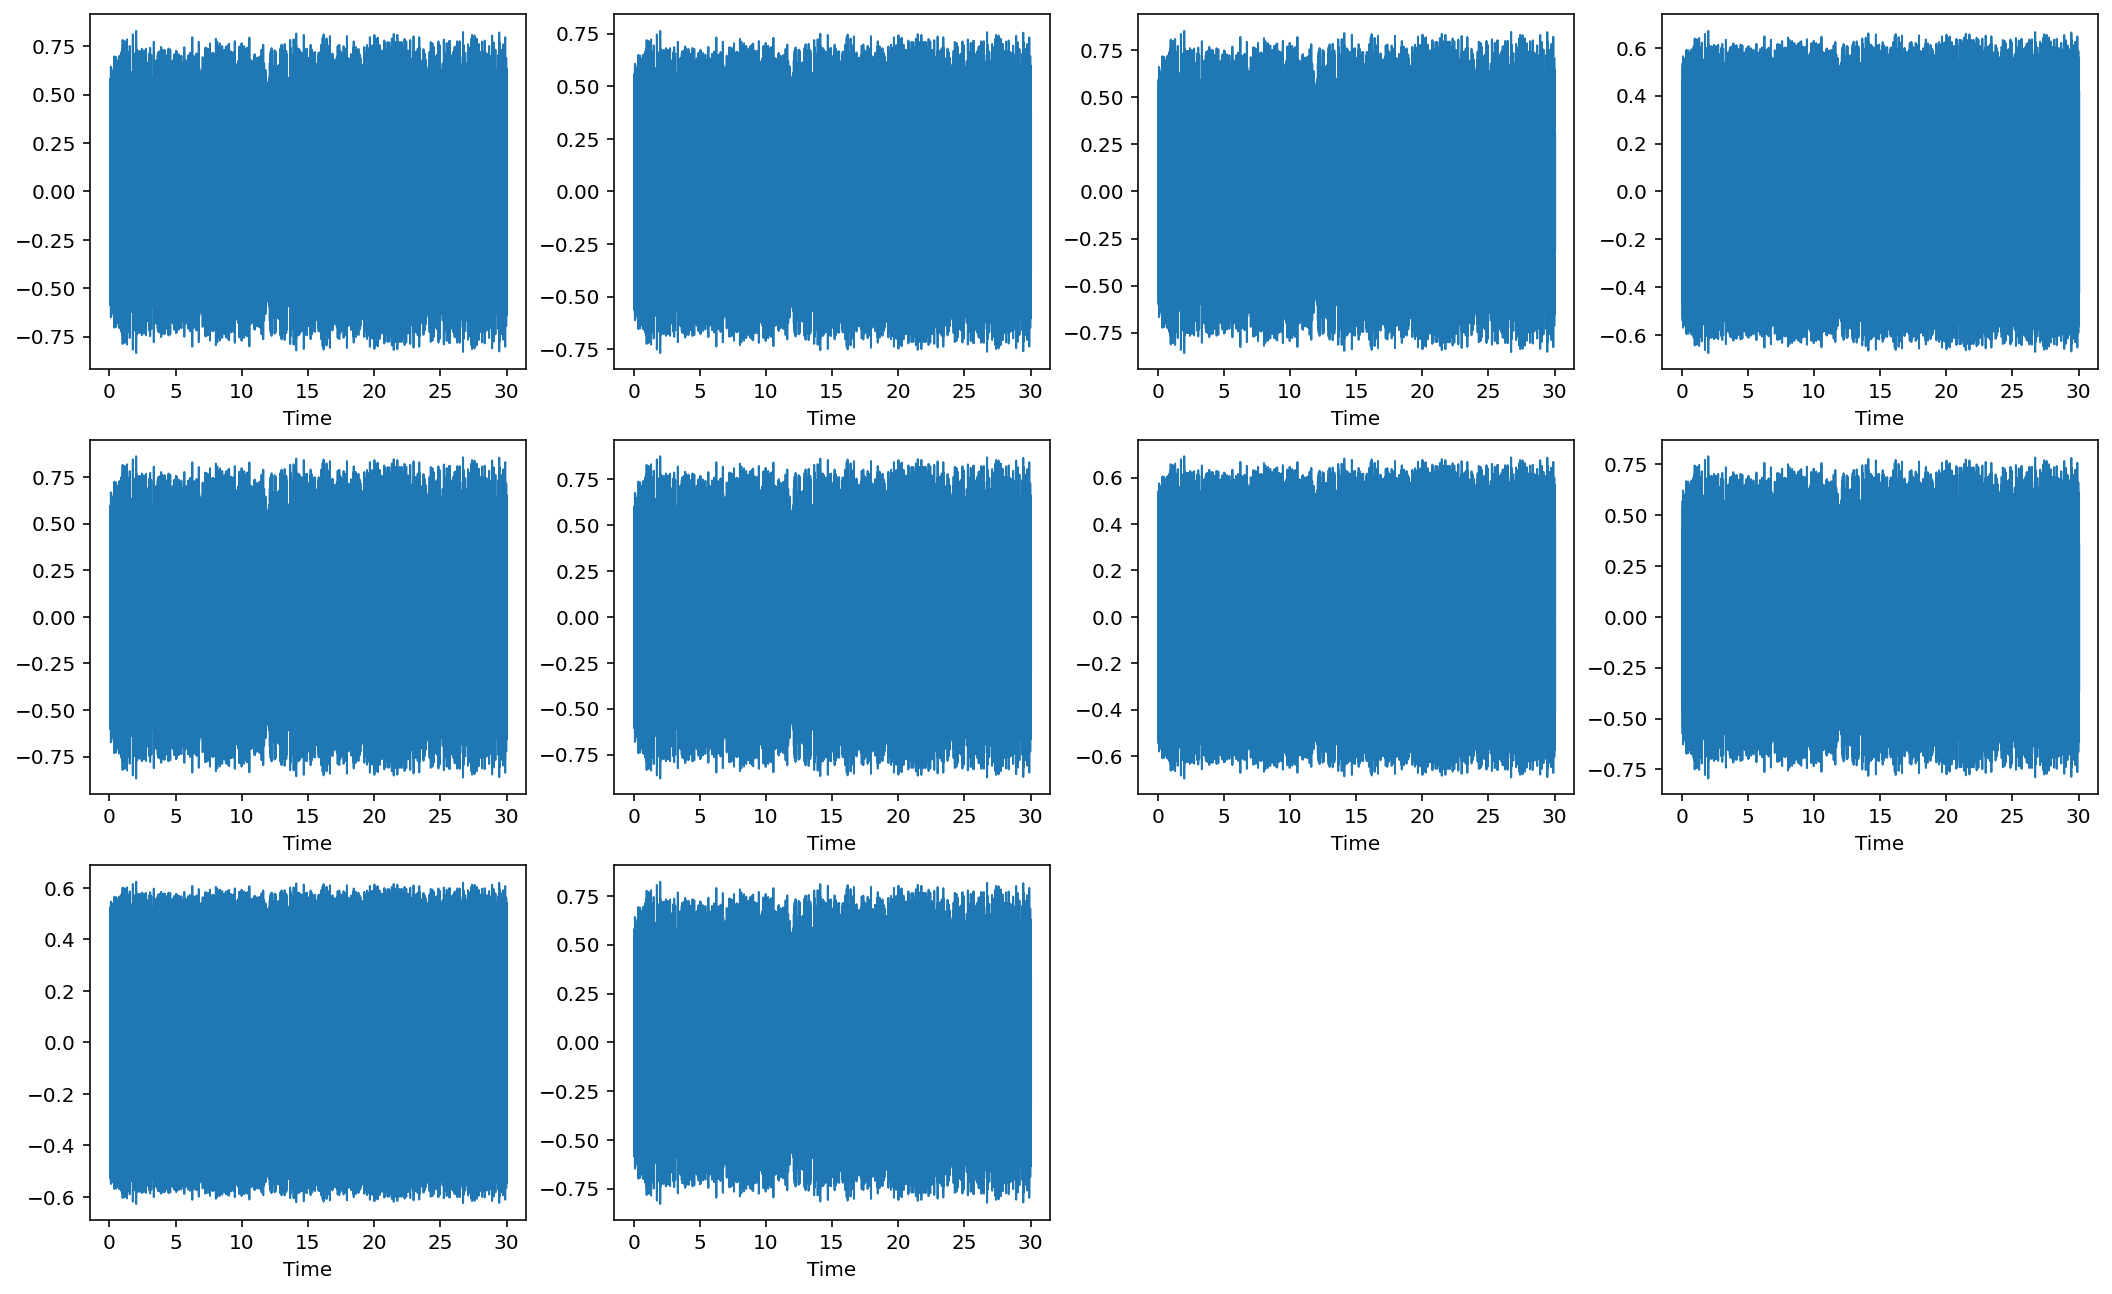

In [101]:
generate_and_save_images(model, 1, test_sample, 'Ts_cropped')
def train_ts(train_dataset_ts, test_dataset_ts, model, save): 
    """
    Trains the model for a given number of epochs. 
    """
    for epoch in range(1 , epochs + 1):
        start_time = time.time()
        for train_x in train_dataset_ts: 
            train_x = np.asarray(train_x)[0] 
            train_step(model, train_x, optimizer)
        end_time = time.time()
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset_ts: 
            test_x = np.asarray(test_x)[0] 
            loss(compute_loss(model, test_x))
        display.clear_output(wait=False)
        elbo = -loss.result()
        print('Epoch Number: {}, Test set ELBO: {}, The time elapse for current epoch: {}'.format(epoch, 
                                                                                        elbo, 
                                                                                        end_time - start_time
                                                                                          ))
        generate_and_save_images(model,
                                    epoch, 
                                    test_sample,
                                    save)
train_ts(train_dataset_ts, test_dataset_ts, model, 'TS_cropped')

## Listening to Model Generated Music ## 

In [102]:
def inference(test_dataset, model):  
    save_music = []
    for test in test_dataset:
        mean, logvar = model.encode(test)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        for pred in predictions:
            wave = np.asarray(pred)
            save_music.append(wave)
    return save_music

saved_musics = inference(test_dataset_ts, model)

In [103]:
music1 = saved_musics[0] 
import soundfile as sf
sf.write('music1.wav', music1[0], 3000)


music2 = saved_musics[1] 
sf.write('music2.wav', music2[0], 3000)

In [104]:
ipd.Audio('music1.wav', rate=3000)